In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt

import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms

import numpy

from IPython.display import Image
from tqdm.notebook import tqdm
from math import *

In [2]:
# Set dataset and model

# Dataset
dataset = torchvision.datasets.oxford_iiit_pet

# Pre-trained model
from torchvision.models import resnet152
model = resnet152(pretrained=True)

model_filename = "pets-resnet152"

warmup_epoch = 3
num_epoch = 7

lr_warmup = 1e-3
lr_base = 1e-2
lr_min = 1e-3

device = "cuda:3" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda:3'

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.CenterCrop(224)
])
train_set = torchvision.datasets.OxfordIIITPet("./data", split= "trainval", download = True, transform=transform)
test_set = torchvision.datasets.OxfordIIITPet("./data", split= "test", download = True, transform=transform)
train_loader = DataLoader(train_set, batch_size=512, shuffle=True)
test_loader = DataLoader(test_set, batch_size=512, shuffle=True)

In [5]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
in_features = model.fc.in_features
in_features

2048

In [7]:
model.fc = nn.Linear(in_features, 37) # set in_features and out_features
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
# Freeze layers
for name, param in model.named_parameters():
    if ('fc' in name) or ('layer4' in name):# or ('layer3' in name)
        print("Unfreeze " + name)
        param.requires_grad = True
    else:
        print("Freeze " + name)
        param.requires_grad = False

Freeze conv1.weight
Freeze bn1.weight
Freeze bn1.bias
Freeze layer1.0.conv1.weight
Freeze layer1.0.bn1.weight
Freeze layer1.0.bn1.bias
Freeze layer1.0.conv2.weight
Freeze layer1.0.bn2.weight
Freeze layer1.0.bn2.bias
Freeze layer1.0.conv3.weight
Freeze layer1.0.bn3.weight
Freeze layer1.0.bn3.bias
Freeze layer1.0.downsample.0.weight
Freeze layer1.0.downsample.1.weight
Freeze layer1.0.downsample.1.bias
Freeze layer1.1.conv1.weight
Freeze layer1.1.bn1.weight
Freeze layer1.1.bn1.bias
Freeze layer1.1.conv2.weight
Freeze layer1.1.bn2.weight
Freeze layer1.1.bn2.bias
Freeze layer1.1.conv3.weight
Freeze layer1.1.bn3.weight
Freeze layer1.1.bn3.bias
Freeze layer1.2.conv1.weight
Freeze layer1.2.bn1.weight
Freeze layer1.2.bn1.bias
Freeze layer1.2.conv2.weight
Freeze layer1.2.bn2.weight
Freeze layer1.2.bn2.bias
Freeze layer1.2.conv3.weight
Freeze layer1.2.bn3.weight
Freeze layer1.2.bn3.bias
Freeze layer2.0.conv1.weight
Freeze layer2.0.bn1.weight
Freeze layer2.0.bn1.bias
Freeze layer2.0.conv2.weight
F

In [9]:
# Reading whole dataloader into memory can improve the speed of training
train_loader = list(train_loader)
test_loader = list(test_loader)

In [10]:
train_set

Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: ./data
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
           )

In [11]:
loss_function = nn.CrossEntropyLoss()

In [12]:
lr = lr_base
def adjust_learning_rate(optimizer, current_epoch, max_epoch, lr_min=lr_min, lr_max=lr_base, warmup=True):
    if current_epoch < warmup_epoch:
        lr = lr_max * (current_epoch+1) / (warmup_epoch+1)
    else:
        lr = lr_min + (lr_max-lr_min)*(1 + cos(pi * (current_epoch - warmup_epoch) / (max_epoch - warmup_epoch))) / 2
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    print("Learning rate is set to "+str(lr))

optimiser = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), 
                      lr=lr,
                      momentum=0.9) #only optimse non-frozen layers
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
results = []

for epoch in range(warmup_epoch+num_epoch):
    running_loss = 0
    train_acc = 0
    
    adjust_learning_rate(optimizer=optimiser,
                        current_epoch=epoch,
                        max_epoch=warmup_epoch+num_epoch)
    with tqdm(train_loader, desc='Train(epoch'+str(epoch)+')') as t:
        total = 0
        correct = 0
        for data in t:
            model.train()
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimiser.zero_grad()

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            running_loss += loss.item()
            loss.backward()
            optimiser.step()
            
            pred = torch.argmax(F.softmax(outputs), dim=1)
            total += len(labels)
            correct += sum(pred == labels)
            
        train_acc = (100.0 * correct) / total

        t.set_postfix(running_loss=running_loss,
                      runing_acc=train_acc)
            
    print("epoch %d/%d:(tr)loss=%.4f" % (epoch, warmup_epoch+num_epoch, running_loss))
    print("epoch %d/%d:(tr)acc=%.4f%%" % (epoch, warmup_epoch+num_epoch, train_acc))
    
    test_running_loss = 0
    test_acc = 0
            
    with tqdm(test_loader, desc='test'+str(epoch)) as t:
        with torch.no_grad():
            total = 0
            correct = 0
            for data in t:
                model.eval()
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)

                loss = loss_function(outputs, labels)
                test_running_loss += loss.item()

                pred = torch.argmax(F.softmax(outputs), dim=1)
                total += len(labels)
                correct += sum(pred == labels)
            test_acc = (100.0 * correct) / total

            t.set_postfix(running_loss=test_running_loss,
                          runing_acc=test_acc)

        print("epoch %d/%d:(te)loss=%.4f" % (epoch, warmup_epoch+num_epoch, test_running_loss))
        print("epoch %d/%d:(te)acc=%.4f%%" % (epoch, warmup_epoch+num_epoch, test_acc))
          
    results.append({'running_loss':running_loss,
                   'train_acc':train_acc,
                   'test_running_loss':test_running_loss,
                   'test_acc':test_acc})


Learning rate is set to 0.0025


Train(epoch0):   0%|          | 0/8 [00:00<?, ?it/s]

/home/hf5n21/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0/10:(tr)loss=28.4177
epoch 0/10:(tr)acc=6.2228%


test0:   0%|          | 0/8 [00:00<?, ?it/s]

/home/hf5n21/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0/10:(te)loss=26.3382
epoch 0/10:(te)acc=21.3137%
Learning rate is set to 0.005


Train(epoch1):   0%|          | 0/8 [00:00<?, ?it/s]

epoch 1/10:(tr)loss=22.2832
epoch 1/10:(tr)acc=53.7500%


test1:   0%|          | 0/8 [00:00<?, ?it/s]

epoch 1/10:(te)loss=16.1872
epoch 1/10:(te)acc=70.7550%
Learning rate is set to 0.0075


Train(epoch2):   0%|          | 0/8 [00:00<?, ?it/s]

epoch 2/10:(tr)loss=11.6389
epoch 2/10:(tr)acc=83.4511%


test2:   0%|          | 0/8 [00:00<?, ?it/s]

epoch 2/10:(te)loss=5.6946
epoch 2/10:(te)acc=86.6994%
Learning rate is set to 0.010000000000000002


Train(epoch3):   0%|          | 0/8 [00:00<?, ?it/s]

epoch 3/10:(tr)loss=4.5290
epoch 3/10:(tr)acc=92.2554%


test3:   0%|          | 0/8 [00:00<?, ?it/s]

epoch 3/10:(te)loss=2.7429
epoch 3/10:(te)acc=91.3600%
Learning rate is set to 0.009554359905560885


Train(epoch4):   0%|          | 0/8 [00:00<?, ?it/s]

epoch 4/10:(tr)loss=2.2974
epoch 4/10:(tr)acc=94.7826%


test4:   0%|          | 0/8 [00:00<?, ?it/s]

epoch 4/10:(te)loss=2.1746
epoch 4/10:(te)acc=92.5865%
Learning rate is set to 0.008305704108364302


Train(epoch5):   0%|          | 0/8 [00:00<?, ?it/s]

epoch 5/10:(tr)loss=1.5832
epoch 5/10:(tr)acc=95.7065%


test5:   0%|          | 0/8 [00:00<?, ?it/s]

epoch 5/10:(te)loss=1.9932
epoch 5/10:(te)acc=93.0226%
Learning rate is set to 0.006501344202803416


Train(epoch6):   0%|          | 0/8 [00:00<?, ?it/s]

epoch 6/10:(tr)loss=1.2524
epoch 6/10:(tr)acc=96.6576%


test6:   0%|          | 0/8 [00:00<?, ?it/s]

epoch 6/10:(te)loss=1.9132
epoch 6/10:(te)acc=93.1861%
Learning rate is set to 0.0044986557971965855


Train(epoch7):   0%|          | 0/8 [00:00<?, ?it/s]

epoch 7/10:(tr)loss=1.0820
epoch 7/10:(tr)acc=97.0380%


test7:   0%|          | 0/8 [00:00<?, ?it/s]

epoch 7/10:(te)loss=1.8729
epoch 7/10:(te)acc=93.3497%
Learning rate is set to 0.0026942958916356995


Train(epoch8):   0%|          | 0/8 [00:00<?, ?it/s]

epoch 8/10:(tr)loss=0.9926
epoch 8/10:(tr)acc=97.3641%


test8:   0%|          | 0/8 [00:00<?, ?it/s]

epoch 8/10:(te)loss=1.8493
epoch 8/10:(te)acc=93.2679%
Learning rate is set to 0.0014456400944391143


Train(epoch9):   0%|          | 0/8 [00:00<?, ?it/s]

epoch 9/10:(tr)loss=0.9474
epoch 9/10:(tr)acc=97.5000%


test9:   0%|          | 0/8 [00:00<?, ?it/s]

epoch 9/10:(te)loss=1.8345
epoch 9/10:(te)acc=93.2407%


In [14]:
results

[{'running_loss': 28.417656421661377,
  'train_acc': tensor(6.2228, device='cuda:3'),
  'test_running_loss': 26.33822774887085,
  'test_acc': tensor(21.3137, device='cuda:3')},
 {'running_loss': 22.283180713653564,
  'train_acc': tensor(53.7500, device='cuda:3'),
  'test_running_loss': 16.18721616268158,
  'test_acc': tensor(70.7550, device='cuda:3')},
 {'running_loss': 11.638884246349335,
  'train_acc': tensor(83.4511, device='cuda:3'),
  'test_running_loss': 5.694606721401215,
  'test_acc': tensor(86.6994, device='cuda:3')},
 {'running_loss': 4.529032200574875,
  'train_acc': tensor(92.2554, device='cuda:3'),
  'test_running_loss': 2.7428847551345825,
  'test_acc': tensor(91.3600, device='cuda:3')},
 {'running_loss': 2.297350287437439,
  'train_acc': tensor(94.7826, device='cuda:3'),
  'test_running_loss': 2.174604430794716,
  'test_acc': tensor(92.5865, device='cuda:3')},
 {'running_loss': 1.5832281336188316,
  'train_acc': tensor(95.7065, device='cuda:3'),
  'test_running_loss': 1.

In [15]:
torch.save(model.state_dict(), "model/" + model_filename)

In [16]:
train_loss_list = []
train_acc_list = []
for result in results:
    train_loss_list.append(result["running_loss"])
    train_acc_list.append(torch.Tensor.cpu(result["train_acc"]))

In [17]:
test_loss_list = []
test_acc_list = []
for result in results:
    test_loss_list.append(result["test_running_loss"])
    test_acc_list.append(torch.Tensor.cpu(result["test_acc"]))

In [18]:
# # 如果Intel的Windows上matplotlib会导致内核重启就执行这个
# import os

# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

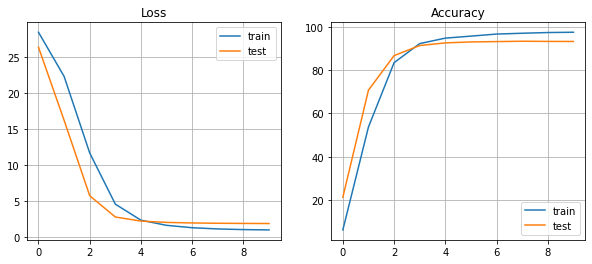

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(train_loss_list)
ax[0].plot(test_loss_list)
ax[0].legend(['train','test'])
ax[0].grid()
ax[0].set_title("Loss")

ax[1].plot(train_acc_list)
ax[1].plot(test_acc_list)
ax[1].legend(['train','test'])
ax[1].grid()
ax[1].set_title("Accuracy")
plt.show()